In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.stats import boxcox

In [2]:
fileName = "3.0_Iris-Dataset.data"

column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']

data = pd.read_csv(fileName, names=column_names)

In [3]:
data.head(20)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
5,5.4,3.9,1.7,0.4,Iris-setosa
6,4.6,3.4,1.4,0.3,Iris-setosa
7,5.0,3.4,1.5,0.2,Iris-setosa
8,4.4,2.9,1.4,0.2,Iris-setosa
9,4.9,3.1,1.5,0.1,Iris-setosa


In [4]:
data.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [6]:
print("Missing values before handling:")
print(data.isnull().sum())

Missing values before handling:
sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64


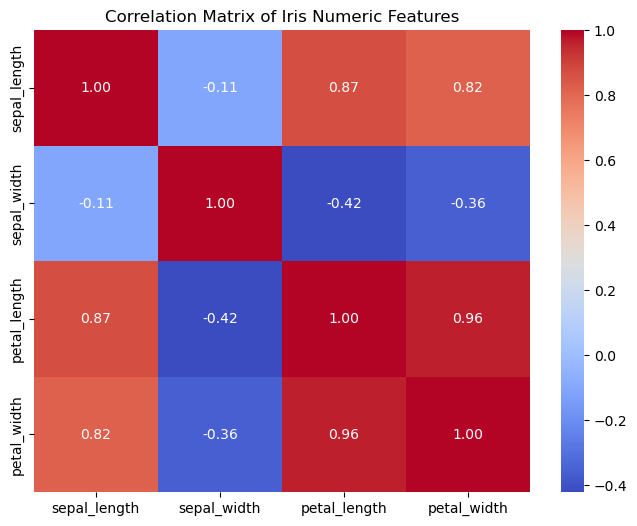

In [7]:
corr_matrix = data.drop('species', axis=1).corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Iris Numeric Features')
plt.show()

In [8]:
data = pd.get_dummies(data, columns=['species'], drop_first=True)

In [10]:
# Normalize
numeric_cols = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
scaler = StandardScaler()
data_normalized = pd.DataFrame(scaler.fit_transform(data[numeric_cols]), columns=numeric_cols)

# Function to perform D'Agostino K^2 test and check normality
def check_normality(column):
    stat, p = stats.normaltest(column)
    return p

# Applying D'Agostino test to original and normalized data
normality_results = {}
for col in numeric_cols:
    p_original = check_normality(data[col])
    p_normalized = check_normality(data_normalized[col])
    normality_results[col] = {'Original p-value': p_original, 'Normalized p-value': p_normalized,
                              'Original Normal': 'Yes' if p_original > 0.05 else 'No',
                              'Normalized Normal': 'Yes' if p_normalized > 0.05 else 'No'}

normality_df = pd.DataFrame(normality_results).T
print("D'Agostino K^2 Test Results (p > 0.05 means normal):\n")
print(normality_df)

D'Agostino K^2 Test Results (p > 0.05 means normal):

             Original p-value Normalized p-value Original Normal  \
sepal_length         0.056824           0.056824             Yes   
sepal_width          0.167241           0.167241             Yes   
petal_length              0.0                0.0              No   
petal_width               0.0                0.0              No   

             Normalized Normal  
sepal_length               Yes  
sepal_width                Yes  
petal_length                No  
petal_width                 No  


In [11]:
# Function to apply transformations and test normality
def apply_transformations(column):
    results = {}
    # Log transformation --> adding 1 to avoid log(0))
    log_transformed = np.log(column + 1)
    p_log = check_normality(log_transformed)
    results['Log'] = p_log
    
    # Square Root transformation
    sqrt_transformed = np.sqrt(column)
    p_sqrt = check_normality(sqrt_transformed)
    results['Square Root'] = p_sqrt
    
    # Box-Cox transformation --> only for positive values)
    if (column > 0).all():
        boxcox_transformed, _ = boxcox(column)
        p_boxcox = check_normality(boxcox_transformed)
        results['Box-Cox'] = p_boxcox
    else:
        results['Box-Cox'] = 'N/A (contains zeros or negatives)'
    
    return results

# Applying transformations to selected columns
transform_results = {}
for col in ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']:
    transform_results[col] = apply_transformations(data[col])

transform_df = pd.DataFrame(transform_results).T
print("\nTransformation Normality Comparison (p-values, > 0.05 means normal):")
print(transform_df)


Transformation Normality Comparison (p-values, > 0.05 means normal):
                       Log   Square Root       Box-Cox
sepal_length  2.255838e-02  3.732121e-02  1.720408e-02
sepal_width   8.759536e-01  7.256267e-01  8.636135e-01
petal_length  2.312657e-64  1.045654e-66  3.321071e-53
petal_width   3.820661e-43  1.912772e-30  2.091644e-36


## Simple Linear Regression

Simple Linear Regression Results:
R2 Score: 0.9282973309202085
Mean Squared Error: 0.04557819994873102


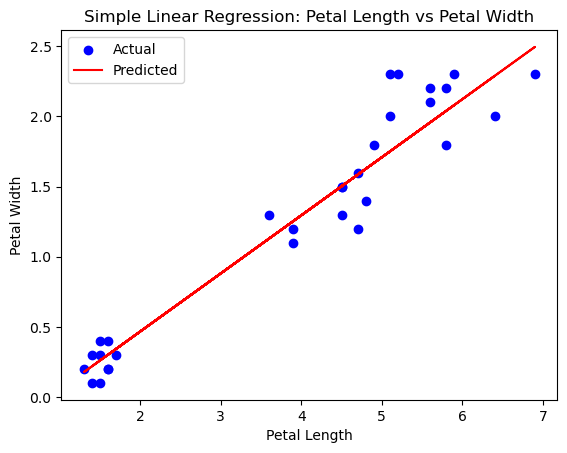

In [12]:
# Using 'petal_length' to predict 'petal_width'
X_simple = data[['petal_length']]
y = data['petal_width']

# Split
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_simple, y, test_size=0.2, random_state=42)

# Train
simple_model = LinearRegression()
simple_model.fit(X_train_s, y_train_s)

# Predict
y_pred_s = simple_model.predict(X_test_s)

# Evaluate
print('Simple Linear Regression Results:')
print('R2 Score:', r2_score(y_test_s, y_pred_s))
print('Mean Squared Error:', mean_squared_error(y_test_s, y_pred_s))

# Visualize
plt.scatter(X_test_s, y_test_s, color='blue', label='Actual')
plt.plot(X_test_s, y_pred_s, color='red', label='Predicted')
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.title('Simple Linear Regression: Petal Length vs Petal Width')
plt.legend()
plt.show()

## Multiple Linear Regression

Multiple Linear Regression Results:
R2 Score: 0.9538424636384966
Mean Squared Error: 0.029340294418947192


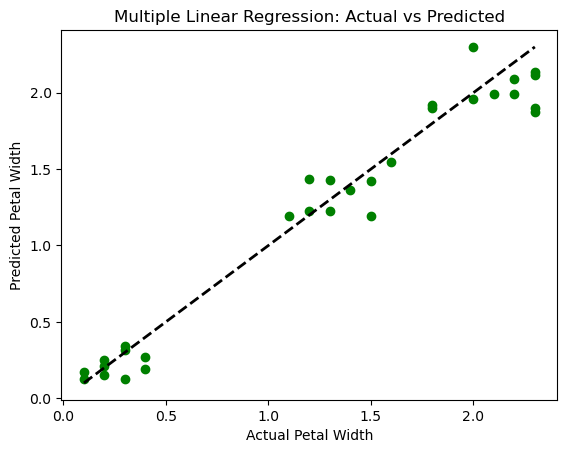

In [13]:
# Using all features to predict 'petal_width'
X_multi = data.drop('petal_width', axis=1)
y = data['petal_width']

# Split
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_multi, y, test_size=0.2, random_state=42)

# Train
multi_model = LinearRegression()
multi_model.fit(X_train_m, y_train_m)

# Predict
y_pred_m = multi_model.predict(X_test_m)

# Evaluate
print('Multiple Linear Regression Results:')
print('R2 Score:', r2_score(y_test_m, y_pred_m))
print('Mean Squared Error:', mean_squared_error(y_test_m, y_pred_m))

# Visualize
plt.scatter(y_test_m, y_pred_m, color='green')
plt.plot([y_test_m.min(), y_test_m.max()], [y_test_m.min(), y_test_m.max()], 'k--', lw=2)
plt.xlabel('Actual Petal Width')
plt.ylabel('Predicted Petal Width')
plt.title('Multiple Linear Regression: Actual vs Predicted')
plt.show()